In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.01,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

In [3]:
def get_sim_mat(Nf, Ra, Rb, sum_lbda=0.1):

    sin_t = np.sin(np.pi/Nf)
    sin_2t = np.sin(2*np.pi/Nf)

    A = 0.5 * (Rb**2 - Ra**2) * sin_2t
    dAdRa = - sin_2t * Ra
    dAdRb = sin_2t * Rb
    dladRa = dlbdRb = 2*sin_t

    # variables are
    # (A - A_0), \Lambda_a, \Lambda_h
    problem_mat = np.array(
        [
            [dAdRa, dladRa, -1],
            [dAdRb, 0,       1],
            [0,     1,       1]
        ])

    b = np.array([0, 0, sum_lbda])
    return problem_mat, b

In [4]:
def _infer_pol(eptm):    
    eptm.get_extra_indices()
    non_lateral_edges = np.concatenate((eptm.apical_edges,
                                        eptm.basal_edges))
    sym_height = (r_out-r_in)*np.cos(np.pi/eptm.Nf)
    polar_coefs = np.ones(eptm.Nf)
    for cell in range(eptm.Nf):
        api_vertex = eptm.edge_df.loc[eptm.apical_edges,
                                      ('srce', 'trgt')][eptm.edge_df.face == cell]
        coord_api_vertex = eptm.vert_df.loc[np.squeeze(api_vertex.values),
                                            ('x', 'y')].values
        coord_cell_center = np.squeeze(eptm.face_df.loc[[cell], ('x', 'y')].values)
        pos_param = np.dot(coord_cell_center - coord_api_vertex[0],
                           coord_cell_center - coord_api_vertex[1])
        comp = np.array((coord_api_vertex[1, 0] - coord_api_vertex[0, 0],
                         coord_api_vertex[1, 1] - coord_api_vertex[0, 1]))
        proj = coord_api_vertex[0] + pos_param * comp
        polar_coefs[cell] = np.linalg.norm(proj - coord_cell_center)
    return polar_coefs

In [5]:
def _system_set_up(eptm, params_in_sym_mesh, polar_coefs):
    matrix = _coef_matrix(eptm, sup_param='areas')
    constant = _right_side(eptm, matrix)
    matrix = matrix[:-1]
    constant = constant[:-1]
    avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
                   (abs(organo.face_df.area.mean() + params_in_sym_mesh[0]))**1.5)]*eptm.Nf
    for i in range(eptm.Nf):
        i_cell_line = np.zeros(4*eptm.Nf+1)
        index = np.squeeze(np.argwhere(eptm.edge_df.face.values == i))
        index_suiv = np.squeeze(np.argwhere(eptm.edge_df.face.values == (i+1)%eptm.Nf))
        index[-1] = index_suiv[-2]
        i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
        matrix = np.vstack((matrix, i_cell_line))
    constant = np.concatenate((constant, avg_cste))
    return matrix, constant

In [6]:
def _tmp_infer_forces(sum_tensions, eptm):
    params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out,
                                                      sum_lbda=sum_tensions))
    polar_coefs = _infer_pol(eptm.copy())
    mat_eq_cst, residuals = nnls(*_system_set_up(eptm,
                                                 params_in_sym_mesh,
                                                 polar_coefs))
    tmp_organo = eptm.copy()
    tmp_organo.edge_df.loc[:, 'line_tension'] = prepare_tensions(tmp_organo,
                                                                 mat_eq_cst[:3*eptm.Nf])
    tmp_organo.face_df.loc[:, 'prefered_area'] = tmp_organo.face_df.area + mat_eq_cst[3*eptm.Nf:
                                                                                      4*eptm.Nf]
    tmp_organo.settings['lumen_prefered_vol'] = tmp_organo.settings['lumen_volume'] + mat_eq_cst[-1]
    Solver.find_energy_min(tmp_organo, geom, model)
    return tmp_organo    

In [7]:
def _opt_cst_obj(sum_tensions, eptm):
    th_eptm = eptm.copy()
    th_settings = eptm.settings.copy()
    exp_eptm = _tmp_infer_forces(sum_tensions, th_eptm).copy()
    eptm.settings['lumen_volume'] = th_settings['lumen_volume']
    dist = np.sum(np.linalg.norm(_distance(th_eptm, exp_eptm), axis=1))
    return dist

Reseting datasets values with new specs


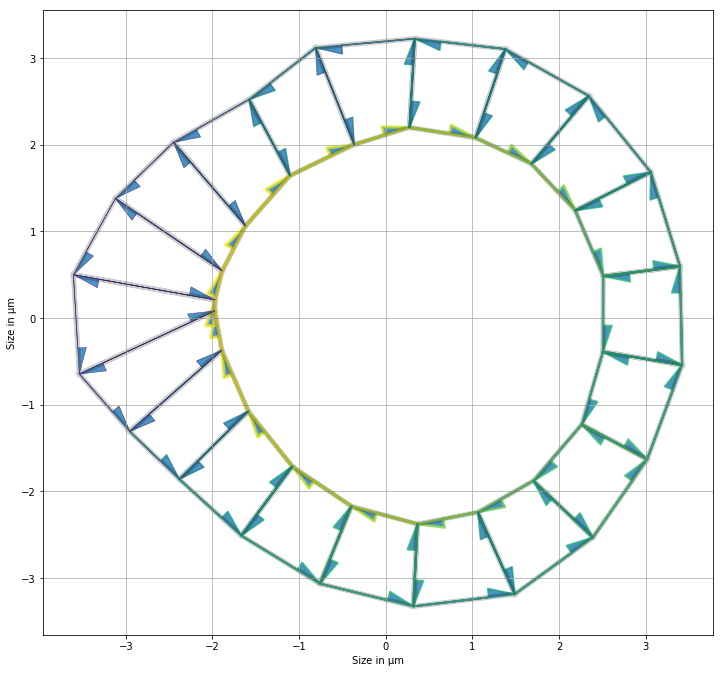

In [8]:
nf, r_in, r_out = (20, 1, 1.5)
seed = 1
organo = create_organo(nf, r_in, r_out)

organo.edge_df.loc[organo.apical_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.060, 0.065, 0.070,
    0.072, 0.074, 0.076, 0.078, 0.078,
    0.079, 0.078, 0.076, 0.074, 0.072,
    0.070, 0.068, 0.065, 0.057, 0.052
])

organo.edge_df.loc[organo.basal_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.045, 0.050,
    0.050, 0.045, 0.035, 0.020, 0.010,
    0.011, 0.015, 0.020, 0.035, 0.030,
    0.040, 0.040, 0.042, 0.045, 0.050
])

organo.edge_df.loc[organo.lateral_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051,
    0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051, 0.050
])

organo.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo.face_df.area

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

## Matrice et constante de l'inférence de forces

In [9]:
organo.edge_df.head()

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,fx,fy,segment,prev,sub_area,ux,uy,uz,line_tension,is_active
edge,,,,,,,,,,,,,,,,,,,,,
0,1,0.383687,0.873412,0,0,-0.244649,-0.838449,2.505490,-0.389034,2.260841,...,2.800145,-0.947523,apical,40,0.191844,-0.280107,-0.959969,0.0,0.150,1
1,2,0.380936,0.855208,1,1,-0.556809,-0.649110,2.260841,-1.227482,1.704032,...,2.342210,-1.816765,apical,41,0.190468,-0.651080,-0.759009,0.0,0.165,1
2,3,0.357000,0.735958,2,2,-0.640262,-0.362902,1.704032,-1.876593,1.063769,...,1.660884,-2.458632,apical,42,0.178500,-0.869971,-0.493102,0.0,0.180,1
3,4,0.343640,0.710704,3,3,-0.697491,-0.136408,1.063769,-2.239495,0.366279,...,0.808607,-2.782078,apical,43,0.171820,-0.981408,-0.191934,0.0,0.195,1
4,5,0.372339,0.788677,4,4,-0.761782,0.204205,0.366279,-2.375904,-0.395504,...,-0.118299,-2.734780,apical,44,0.186169,-0.965899,0.258920,0.0,0.210,1


In [10]:
import time
def mean_nz(edges):
    return edges['nz'].mean()


organo.edge_df.groupby('face').apply(mean_nz)

face
0     0.446705
1     0.435653
2     0.449570
3     0.455920
4     0.448305
5     0.457066
6     0.464841
7     0.480750
8     0.504640
9     0.512420
10    0.515002
11    0.512517
12    0.494531
13    0.485186
14    0.491442
15    0.475430
16    0.469422
17    0.459437
18    0.451422
19    0.452510
dtype: float64

## Cst opt

In [11]:
cst_opt_result = optimize.minimize_scalar(_opt_cst_obj,
                                          args=(organo.copy()),
                                          method='golden')

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [12]:
cst_opt_result_bounded = optimize.minimize_scalar(_opt_cst_obj,
                                                  bounds=[0, 1],
                                                  args=(organo.copy()),
                                                  method='bounded')

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [13]:
cst_opt_result, cst_opt_result_bounded

(     fun: 4.461221018146574
     nfev: 47
      nit: 42
  success: True
        x: 0.21044661101386153,      fun: 4.461224603768696
  message: 'Solution found.'
     nfev: 21
   status: 0
  success: True
        x: 0.21044793454017252)

Calcul des paramètres dans l'organoïde régulier

In [14]:
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out, sum_lbda=cst_opt_result.x))

Calcul du "coefficient de polarisation", avec le 

In [15]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    api_vertex = organo.edge_df.loc[organo.apical_edges,
                                    ('srce', 'trgt')][organo.edge_df.face == cell]
    coord_api_vertex = organo.vert_df.loc[np.squeeze(api_vertex.values),
                                          ('x', 'y')].values
    coord_cell_center = np.squeeze(organo.face_df.loc[[cell], ('x', 'y')].values)
    #((C(1,1)-A(1,1))*(B(1,1)-A(1,1)))+((C(1,2)-A(1,2))*(B(1,2)-A(1,2)))
    pos_param = np.dot(coord_cell_center - coord_api_vertex[0],
                       coord_cell_center - coord_api_vertex[1])
    comp = np.array((coord_api_vertex[1, 0] - coord_api_vertex[0, 0],
                     coord_api_vertex[1, 1] - coord_api_vertex[0, 1]))
    proj = coord_api_vertex[0] + pos_param * comp
    #api_vert = organo.vert_df.loc[organo.apical_verts[[cell, (cell+1)%organo.Nf]],
    #                              ('x', 'y')].values
    polar_coefs[cell] = np.linalg.norm(proj - coord_cell_center)
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.6298519 , 0.58552087, 0.54554701, 0.5578145 , 0.57129197,
       0.57944321, 0.56423776, 0.59851501, 0.78701856, 0.81035332,
       0.76745019, 0.70391654, 0.6724686 , 0.63208301, 0.60714558,
       0.60834998, 0.59372321, 0.59204298, 0.62304487, 0.62635186])

[0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226]
-4.396350112139614
[0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226, 0.6725833520927226]
(100, 81) (100,)
[0.19312778 0.19079076 0.22567391 0.23029608 0.22152948 0.23343033
 0.25303212 0.29366369 0.34183887 0.38494874 0.37053794 0.34623026
 0.29508967 0.27617354 0.283

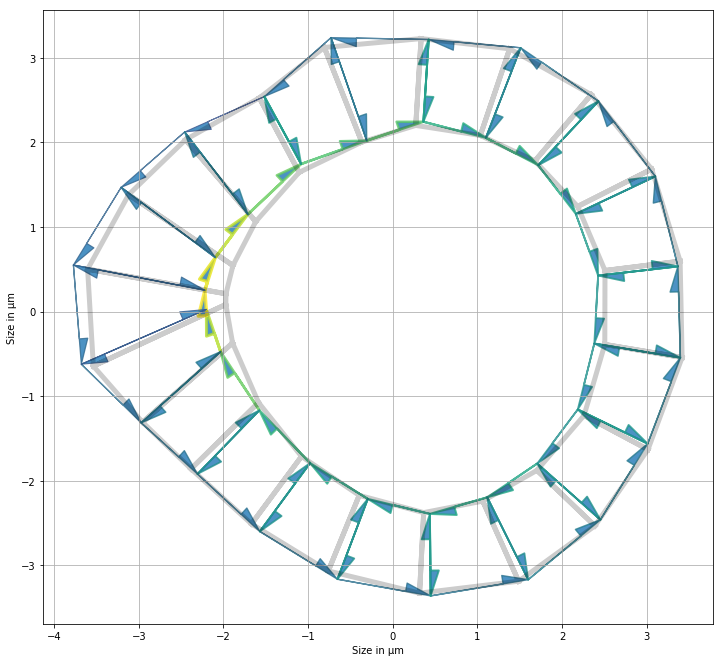

In [16]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
matrix = matrix[:-1]
constant = constant[:-1]
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
#avg_cste = [2.44/(3*organo.Nf)*4]*organo.Nf
print(avg_cste)
#avg_cste = np.multiply(np.array(avg_cste), polar_coefs)
#area_ela_line = np.concatenate((np.zeros(organo.Nf*3),
#                                np.ones(organo.Nf),
#                                [0]))
#matrix = np.vstack((matrix, area_ela_line))
#constant = np.concatenate((constant, [-params_in_sym_mesh[0]*organo.Nf]))
print(params_in_sym_mesh[0]*organo.Nf)
print(avg_cste)
for i in range(organo.Nf):
    i_cell_line = np.zeros(4*organo.Nf+1)
    index = np.squeeze(np.argwhere(organo.edge_df.face.values == i))
    index_suiv = np.squeeze(np.argwhere(organo.edge_df.face.values == (i+1)%organo.Nf))
    index[-1] = index_suiv[-2]
    #index[-1] = 40
    #print(index)
    i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
    #print(i_cell_line)
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
print(matrix.shape, constant.shape)
mat_eq_cst, residuals = nnls(matrix, constant)
organo_eq_cst = organo.copy()
organo_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_eq_cst,
                                                                 mat_eq_cst[:3*organo.Nf])
organo_eq_cst.face_df.loc[:, 'prefered_area'] = organo_eq_cst.face_df.area + mat_eq_cst[3*organo.Nf:
                                                                                          4*organo.Nf]
organo_eq_cst.settings['lumen_prefered_vol'] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo_eq_cst, geom, model)
print_tensions(organo_eq_cst, organo)
print(mat_eq_cst[organo.apical_edges])
print('Apical tensions: ', mat_eq_cst[organo.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo.lateral_edges[:organo.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance from th org to exp org: ', np.sum(np.linalg.norm(_distance(organo_eq_cst, organo), axis=1)),
      '\nNNLS residuals: ', residuals)

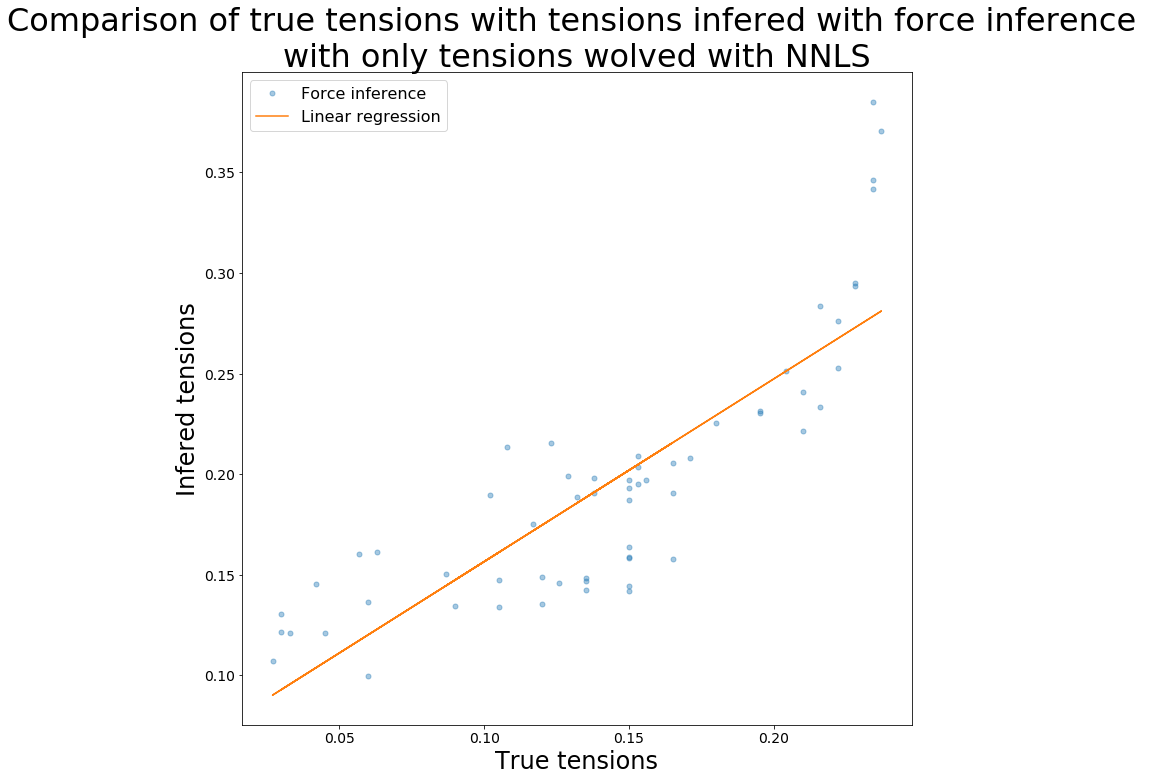

R value : 0.8365321021907077 
Standard error : 0.030288025400014074


In [17]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  mat_eq_cst[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [18]:
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
start_copy = time.time()
iprint_file = "../../assets/dist_at_each_f_ev/14_03_eq_t_per_cell_new_criteria.txt"
to_opt_organo = organo.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas_copy = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    COPY_OR_SYM='copy',                                    
                                    **lm_opt)
end_copy = time.time()
print('Execution time: ', start_copy - end_copy)

4.5163474165710875 [0.10918103 0.08840764 0.07345193 0.06706795 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

4.516347425870148 [0.10918103 0.08840764 0.07345193 0.06706794 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

4.516347390433375 [0.10918103 0.08840764 0.07345193 0.06706794 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708036 0.26167607 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17614    0.13002573 0.10088292 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

4.51634741108432 [0.10918103 0.08840764 0.07345193 0.06706794 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671929 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.061106   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

4.516347429675651 [0.10918103 0.08840764 0.07345193 0.06706794 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475579 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

4.516347403369834 [0.10918103 0.08840764 0.07345193 0.06706794 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

4.516347410848628 [0.10918103 0.08840764 0.07345193 0.06706795 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

4.516347436427527 [0.10918103 0.08840764 0.07345193 0.06706795 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475579 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

4.516347424439604 [0.10918103 0.08840764 0.07345193 0.06706795 0.07781654 0.11036429
 0.13013376 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475579 0.11617078
 0.13865332 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

4.516347433255633 [0.10918103 0.08840764 0.07345193 0.06706795 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708036 0.26167606 0.23745228
 0.13924927 0.11394567 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002573 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

4.516347407417692 [0.10918103 0.08840764 0.07345193 0.06706794 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

4.5163474165710875 [0.10918103 0.08840764 0.07345193 0.06706795 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

4.5163474165710875 [0.10918103 0.08840764 0.07345193 0.06706795 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

4.5163474165710875 [0.10918103 0.08840764 0.07345193 0.06706795 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

4.516347375527685 [0.10918103 0.08840764 0.07345192 0.06706794 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.06156359 0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617077
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.061106   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

4.516347422414833 [0.10918103 0.08840764 0.07345193 0.06706795 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671928 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865332 0.1521738  0.13544545 0.09447124 0.02841147 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.13556581 0.11406903 0.09480458 0.061106   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

4.516347446358676 [0.10918103 0.08840764 0.07345193 0.06706795 0.07781654 0.11036429
 0.13013377 0.10455991 0.18770139 0.24708036 0.26167606 0.23745227
 0.13924927 0.11394566 0.0615636  0.10671929 0.0702053  0.06418642
 0.08302447 0.08798925 0.01008849 0.06350577 0.09475578 0.11617078
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.0597473  0.14997167 0.08989466
 0.13556581 0.11406903 0.09480458 0.06110601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

4.516347354779313 [0.10918103 0.08840764 0.07345193 0.06706794 0.07781654 0.11036428
 0.13013377 0.10455991 0.18770139 0.24708035 0.26167606 0.23745227
 0.13924927 0.11394566 0.06156359 0.10671928 0.0702053  0.06418642
 0.08302447 0.08798924 0.01008849 0.06350576 0.09475578 0.11617077
 0.13865331 0.15217379 0.13544545 0.09447124 0.02841146 0.14868725
 0.17613999 0.13002574 0.10088293 0.05974731 0.14997166 0.08989465
 0.1355658  0.11406903 0.09480458 0.061106   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.3240415463838167 [0.02123244 0.0050718  0.07781667 0.04280368 0.05901595 0.01002304
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094096 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310442 0.04698435
 0.02451343 0.06196974 0.03240699 0.07560402 0.0962018  0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

2.324041496270241 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002304
 0.01036694 0.06107461 0.11215647 0.03549612 0.02515446 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094096 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310441 0.04698434
 0.02451344 0.06196975 0.03240699 0.07560402 0.0962018  0.07911265
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.3240415471198563 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769987 0.03926653 0.03027509 0.06659017 0.03094095 0.05071193
 0.09988073 0.08183063 0.08856937 0.07345445 0.03310441 0.04698434
 0.02451344 0.06196975 0.032407   0.07560402 0.09620181 0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863726 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

2.324041550942007 [0.02123244 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094096 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310441 0.04698434
 0.02451344 0.06196975 0.03240699 0.07560402 0.0962018  0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.3240415560050325 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094096 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310441 0.04698434
 0.02451344 0.06196975 0.032407   0.07560402 0.0962018  0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

2.324041544643885 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094096 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310441 0.04698434
 0.02451344 0.06196975 0.03240699 0.07560402 0.09620181 0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.324041549702841 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094096 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345445 0.03310441 0.04698434
 0.02451344 0.06196975 0.03240699 0.07560402 0.0962018  0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.100059   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.324041555531258 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901596 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094095 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345445 0.03310442 0.04698434
 0.02451343 0.06196975 0.032407   0.07560402 0.09620181 0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.324041535706621 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769987 0.03926653 0.03027509 0.06659016 0.03094095 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310441 0.04698434
 0.02451343 0.06196975 0.03240699 0.07560402 0.0962018  0.07911266
 0.05054833 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.3240415612528684 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.0302751  0.06659016 0.03094096 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310441 0.04698434
 0.02451344 0.06196975 0.03240699 0.07560402 0.0962018  0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

2.324041550669109 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094095 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310441 0.04698434
 0.02451344 0.06196975 0.03240699 0.07560402 0.0962018  0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.324041550669109 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094095 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310441 0.04698434
 0.02451344 0.06196975 0.03240699 0.07560402 0.0962018  0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.324041550669109 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094095 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310441 0.04698434
 0.02451344 0.06196975 0.03240699 0.07560402 0.0962018  0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.324041558266769 [0.02123244 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094096 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345445 0.03310441 0.04698435
 0.02451344 0.06196975 0.032407   0.07560402 0.09620181 0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.3240415576992794 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094096 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310441 0.04698434
 0.02451343 0.06196975 0.03240699 0.07560403 0.09620181 0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

2.324041559256216 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094095 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310441 0.04698434
 0.02451344 0.06196975 0.03240699 0.07560402 0.0962018  0.07911266
 0.05054834 0.02237818 0.14657685 0.1036004  0.13362984 0.01843799
 0.04848725 0.02863727 0.02216453 0.10005901 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.324041570930841 [0.02123245 0.0050718  0.07781667 0.04280368 0.05901595 0.01002305
 0.01036694 0.06107461 0.11215648 0.03549614 0.02515445 0.04019257
 0.13769986 0.03926653 0.03027509 0.06659016 0.03094096 0.05071194
 0.09988073 0.08183063 0.08856937 0.07345444 0.03310441 0.04698434
 0.02451344 0.06196975 0.03240699 0.07560402 0.0962018  0.07911266
 0.05054834 0.02237817 0.14657684 0.10360039 0.13362984 0.01843799
 0.04848726 0.02863727 0.02216453 0.10005902 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9478410493911262 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383556 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9478410294637818 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.0481918  0.07326258 0.07587828 0.12456693 0.10000484
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623645 0.06279951 0.01789761 0.02373978 0.06063966 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9478410263645634 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456693 0.10000484
 0.06754507 0.02366545 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225491 0.02726397 0.04063517 0.07464584
 0.05783189 0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.947841041443255 [0.00478261 0.0081394  0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9478410351639495 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623645 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.947841038246842 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000484
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9478410397307178 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169906 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563362 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9478410338588619 [0.00478262 0.00813941 0.03861001 0.02341945 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383556 0.02791248 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.947841040593107 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9478410404856716 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169905 0.05669835 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464583
 0.0578319  0.02563362 0.01773527 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9478410376281756 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9478410376281756 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9478410376281756 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9478410376281756 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9478410592989337 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341598 0.06098469
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598027
 0.07623646 0.06279952 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.947841062183413 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754507 0.02366544 0.06169906 0.05669834 0.03099098 0.02394036
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819947 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563362 0.01773526 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9478410508308475 [0.00478262 0.00813941 0.03861001 0.02341944 0.04341597 0.06098468
 0.0578325  0.04819181 0.07326257 0.07587828 0.12456694 0.10000485
 0.06754506 0.02366544 0.06169905 0.05669834 0.03099098 0.02394035
 0.04061577 0.02817465 0.03501052 0.03383555 0.02791247 0.03598026
 0.07623646 0.06279951 0.01789762 0.02373977 0.06063965 0.06953022
 0.08437226 0.08819946 0.05225492 0.02726396 0.04063517 0.07464584
 0.0578319  0.02563361 0.01773527 0.04326788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.8339966663699698 [0.07586209 0.07149701 0.06853848 0.04776152 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543427 0.05192478
 0.01460885 0.05436289 0.0350658  0.04298624 0.03230845 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876097 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.8339966818229165 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585764 0.04306428 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543428 0.05192477
 0.01460884 0.05436289 0.0350658  0.04298624 0.03230845 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.8339966723432384 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052704 0.0133006  0.01685673 0.02173738 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543427 0.05192477
 0.01460884 0.05436289 0.03506579 0.04298625 0.03230846 0.02519196
 0.03720434 0.06512093 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.83399666590115 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853789 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543427 0.05192478
 0.01460885 0.05436289 0.0350658  0.04298624 0.03230845 0.02519197
 0.03720434 0.06512092 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.8339966751296113 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306428 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319992 0.03597501 0.0475559  0.03806995 0.05543427 0.05192477
 0.01460884 0.05436289 0.0350658  0.04298624 0.03230845 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.8339966728189832 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543427 0.05192478
 0.01460885 0.05436289 0.0350658  0.04298624 0.03230845 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.8339966710335944 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543427 0.05192477
 0.01460885 0.05436289 0.0350658  0.04298624 0.03230845 0.02519197
 0.03720434 0.06512092 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.8339966753734371 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319992 0.03597501 0.04755591 0.03806995 0.05543427 0.05192477
 0.01460884 0.05436289 0.03506579 0.04298624 0.03230845 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.833996666055551 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306428 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543427 0.05192477
 0.01460885 0.05436289 0.0350658  0.04298624 0.03230845 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876097 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.833996672738594 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543427 0.05192477
 0.01460885 0.0543629  0.0350658  0.04298624 0.03230846 0.02519196
 0.03720434 0.06512093 0.0667822  0.06876097 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.8339966729662132 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543427 0.05192477
 0.01460884 0.05436289 0.0350658  0.04298624 0.03230845 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.8339966729662132 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543427 0.05192477
 0.01460884 0.05436289 0.0350658  0.04298624 0.03230845 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.8339966729662132 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543427 0.05192477
 0.01460884 0.05436289 0.0350658  0.04298624 0.03230845 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.8339966729662132 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543427 0.05192477
 0.01460884 0.05436289 0.0350658  0.04298624 0.03230845 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.8339966745986294 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.04755591 0.03806995 0.05543427 0.05192478
 0.01460885 0.05436289 0.03506579 0.04298624 0.03230845 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.8339966917736024 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052704 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075556 0.05853788 0.055642   0.05578155 0.07935457
 0.05319992 0.03597501 0.04755591 0.03806995 0.05543426 0.05192477
 0.01460885 0.0543629  0.0350658  0.04298624 0.03230845 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.833996687432212 [0.07586209 0.07149701 0.06853848 0.04776153 0.04531611 0.02573057
 0.02586042 0.05585765 0.04306427 0.05712912 0.03681846 0.05357121
 0.03636849 0.02052703 0.0133006  0.01685673 0.02173739 0.02997016
 0.05360535 0.06075557 0.05853788 0.055642   0.05578155 0.07935457
 0.05319991 0.03597501 0.0475559  0.03806995 0.05543427 0.05192477
 0.01460884 0.05436289 0.0350658  0.04298624 0.03230846 0.02519197
 0.03720434 0.06512093 0.0667822  0.06876097 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.5670063147107571 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.0353461  0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5670063153680565 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061428 0.05763195 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392336 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.03534611 0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.567006314945661 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092225 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223614 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.03534611 0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.5670063152589915 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.03534611 0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5670063149505404 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763195 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.03534611 0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5670063157127818 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.0353461  0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.567006315897134 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682993 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.03534611 0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.5670063150425952 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.02823799 0.04725682
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.0353461  0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5670063196181598 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763195 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.0353461  0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5670063137302395 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677954 0.03120645
 0.03005718 0.0400715  0.0353461  0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5670063156836866 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.03534611 0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5670063156836866 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.03534611 0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5670063156836866 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.03534611 0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5670063156836866 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.03534611 0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5670063268086523 [0.03799035 0.03669286 0.04329488 0.03068927 0.03647109 0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725682
 0.03798118 0.03392337 0.03967703 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.0400715  0.03534611 0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5670063355018853 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763195 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682994 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.04007151 0.03534611 0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5670063276205044 [0.03799035 0.03669286 0.04329488 0.03068927 0.0364711  0.03366668
 0.03061429 0.05763194 0.04744376 0.06030718 0.06741259 0.05547327
 0.04092224 0.03229402 0.02409683 0.02974027 0.02682993 0.02872303
 0.03779556 0.03440115 0.03644583 0.0348883  0.028238   0.04725681
 0.03798117 0.03392337 0.03967702 0.03662817 0.05238669 0.04525747
 0.04073741 0.05223615 0.03195797 0.04334055 0.03677955 0.03120645
 0.03005718 0.04007151 0.0353461  0.04009944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.5020544673558671 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.502054471723657 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653174 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506659 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.5020544635236175 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724804 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713268 0.04658191 0.03288487 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.502054467277294 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703266 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.5020544683964316 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.5020544674990823 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713268 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.502054467405875 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.502054466183686 [0.03580175 0.03554356 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446498 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.5020544661012025 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653174 0.05055822 0.03555598 0.05724804 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211466 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.5020544666326563 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.04159909 0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.5020544667434517 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444116 0.03446498 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703266 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.5020544673558671 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.5020544673558671 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.5020544673558671 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.5020544799326716 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.04280991
 0.03556208 0.03064419 0.03506659 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.50205447813997 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752599 0.03015409 0.0245544  0.03166735 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

1.5020544796771929 [0.03580175 0.03554355 0.04102228 0.03421039 0.03898252 0.0338937
 0.02653173 0.05055822 0.03555599 0.05724805 0.06157262 0.05313248
 0.03752598 0.03015409 0.0245544  0.03166734 0.02988554 0.03339021
 0.03934806 0.03444115 0.03446497 0.03186611 0.02762744 0.0428099
 0.03556207 0.03064419 0.03506658 0.03980665 0.05211465 0.04981561
 0.03713269 0.04658191 0.03288488 0.0415991  0.03311664 0.03119146
 0.02899139 0.03567388 0.03305162 0.03703267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.5818754448269385 [0.03459168 0.03614925 0.04624831 0.05567814 0.05664015 0.03339036
 0.02727907 0.042121   0.01159216 0.05702831 0.07284721 0.05907978
 0.01250497 0.01313385 0.011333   0.03407273 0.04042434 0.04861398
 0.04984787 0.03962777 0.02854888 0.02604896 0.03294072 0.05167847
 0.04559875 0.01736188 0.03536758 0.05407522 0.04587379 0.06457379
 0.06798655 0.05965805 0.03521124 0.04774898 0.02427025 0.02446741
 0.02946967 0.03753244 0.03661048 0.03464836 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4763980680215871 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.05631851 0.0605525  0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4763980645010635 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.0563185  0.0605525  0.05244936
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.476398066676531 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.05631851 0.0605525  0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132668 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.4763980661479958 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.05631851 0.06055249 0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4763980676037214 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328403 0.0563185  0.06055249 0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204012 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4763980641159593 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.05631851 0.06055249 0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132668 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4763980654595932 [0.03512521 0.03536876 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.05631851 0.06055249 0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343828 0.03038193 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4763980641495704 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.0490259  0.03328402 0.05631851 0.06055249 0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4763980658646751 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.05631851 0.0605525  0.05244937
 0.03632911 0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4763980645450494 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.05631851 0.06055249 0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4763980664417857 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.05631851 0.06055249 0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4763980664417857 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.05631851 0.06055249 0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4763980664417857 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.05631851 0.06055249 0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4763980823788476 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.05631851 0.0605525  0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038193 0.0273698  0.04098172
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.476398083529666 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328403 0.0563185  0.06055249 0.05244937
 0.0363291  0.02949276 0.02445942 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975738
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065026
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.476398086722482 [0.03512521 0.03536877 0.04004759 0.03541762 0.03944569 0.03358976
 0.0254584  0.04902591 0.03328402 0.05631851 0.0605525  0.05244937
 0.0363291  0.02949275 0.02445941 0.03209379 0.0307625  0.03477949
 0.03962211 0.03444941 0.03343829 0.03038192 0.0273698  0.04098171
 0.03459684 0.02917222 0.03287198 0.04019264 0.05204011 0.04975737
 0.03703807 0.04477063 0.03274974 0.04085456 0.03132669 0.03065027
 0.02827986 0.03403554 0.03215107 0.03566687 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.4763985448313686 [0.03512522 0.03536878 0.04004761 0.03541763 0.0394457  0.03358978
 0.02545841 0.0490259  0.03328403 0.05631852 0.06055251 0.05244938
 0.03632911 0.02949276 0.02445943 0.03209381 0.03076251 0.0347795
 0.03962213 0.03444943 0.0334383  0.03038194 0.02736981 0.04098172
 0.03459685 0.02917223 0.03287199 0.04019264 0.05204012 0.04975738
 0.03703807 0.04477064 0.03274975 0.04085457 0.0313267  0.03065027
 0.02827988 0.03403555 0.03215108 0.03566688 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.4300996854467718 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404223 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.430099683061887 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404223 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.4300996837580295 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404222 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4300996834904476 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404222 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.430099685045784 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060979 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404222 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146677 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.4300996816519096 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404222 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4300996828081693 [0.03428808 0.03502341 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404222 0.03256207 0.03202165 0.03667417
 0.03991882 0.0344184  0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.0332108  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4300996821433705 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404222 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4300996832762918 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.0343545  0.028534   0.02404222 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4300996822332324 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404222 0.03256207 0.03202165 0.03667417
 0.03991883 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4300996839359423 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404222 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4300996839359423 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404222 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4300996839359423 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404222 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4300997001504685 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404222 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.430099701458743 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060979 0.05539479 0.05957945 0.05186452
 0.03435449 0.028534   0.02404223 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.04009419 0.05146676 0.04873298
 0.03674889 0.04199379 0.03203929 0.03931751 0.02823948 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.4300997045016364 [0.03428807 0.03502342 0.03861163 0.03716427 0.03999052 0.03279128
 0.0238425  0.04691552 0.03060978 0.05539479 0.05957945 0.05186452
 0.03435449 0.02853399 0.02404222 0.03256207 0.03202165 0.03667417
 0.03991882 0.03441841 0.03128101 0.02782847 0.02657909 0.03800915
 0.03258783 0.02633265 0.02911968 0.0400942  0.05146676 0.04873297
 0.03674889 0.04199379 0.03203929 0.03931752 0.02823949 0.02926979
 0.02675157 0.03143898 0.03045618 0.03321079 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.4301001602566208 [0.03428809 0.03502343 0.03861165 0.03716429 0.03999054 0.0327913
 0.0238425  0.04691551 0.03060979 0.0553948  0.05957946 0.05186454
 0.0343545  0.028534   0.02404224 0.03256208 0.03202167 0.03667419
 0.03991884 0.03441842 0.03128103 0.02782848 0.0265791  0.03800916
 0.03258784 0.02633266 0.02911969 0.0400942  0.05146677 0.04873298
 0.03674889 0.0419938  0.0320393  0.03931752 0.0282395  0.0292698
 0.02675158 0.03143899 0.0304562  0.03321081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.4179002153625362 [0.03412719 0.03499811 0.03826944 0.03751942 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635938 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.0317266  0.03891334 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.4179002174709088 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546757 0.0596191  0.05201266
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649082 0.04122948 0.0317266  0.03891334 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.417900216489381 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220163 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.03172659 0.03891333 0.02740881 0.02878506
 0.02629923 0.03081447 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.4179002152996534 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635938 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.03172659 0.03891334 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.4179002161807568 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032135 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.03172659 0.03891334 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.417900215276849 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.03172659 0.03891333 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.41790021493654 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.03172659 0.03891334 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256251 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.4179002141273664 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.03172659 0.03891334 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.417900214003037 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.05961911 0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.03172659 0.03891333 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.417900214580421 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.03172659 0.03891334 0.02740881 0.02878506
 0.02629924 0.03081447 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.417900216478429 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.03172659 0.03891334 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.417900216478429 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.03172659 0.03891334 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.417900216478429 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.03172659 0.03891334 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.4179002310379416 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715355 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.0317266  0.03891334 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.4179002294015204 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662932 0.03032135 0.05546757 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989232 0.05113475 0.04823746
 0.03649082 0.04122948 0.03172659 0.03891334 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.4179002334669883 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832261 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.0306859  0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122949 0.0317266  0.03891334 0.02740882 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.4179002354563561 [0.03412719 0.03499811 0.03826944 0.03751943 0.04002033 0.0324942
 0.02343522 0.04662931 0.03032136 0.05546758 0.0596191  0.05201267
 0.03409459 0.02832262 0.02386219 0.03257202 0.03220164 0.03698201
 0.03989838 0.03440175 0.03068591 0.02715354 0.02635939 0.03724422
 0.03200074 0.02554616 0.02815431 0.03989233 0.05113474 0.04823746
 0.03649081 0.04122948 0.0317266  0.03891334 0.02740881 0.02878506
 0.02629923 0.03081448 0.03001198 0.03256252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.394830327404818 [0.03390874 0.03494267 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985112 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3948303297700253 [0.03390874 0.03494267 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.02977039 0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985113 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3948303284919361 [0.03390874 0.03494267 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255584 0.03249401 0.03747496
 0.03985112 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3948303273293745 [0.03390874 0.03494266 0.03772465 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985112 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3948303282105656 [0.03390874 0.03494267 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.02977039 0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985112 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.0263917  0.03950659 0.05052428 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3948303273035898 [0.03390874 0.03494267 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985112 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3948303269313604 [0.03390874 0.03494267 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985113 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3948303261375476 [0.03390874 0.03494266 0.03772466 0.0381139  0.0400713  0.03195804
 0.02273819 0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985112 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086854 0.02406469 0.0263917  0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.394830325932468 [0.03390874 0.03494266 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985112 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3948303267281599 [0.03390874 0.03494266 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747497
 0.03985112 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.394830328472266 [0.03390874 0.03494267 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985112 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.394830328472266 [0.03390874 0.03494267 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985112 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.394830328472266 [0.03390874 0.03494267 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985112 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3948303428847653 [0.03390874 0.03494266 0.03772465 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985112 0.03437114 0.02951899 0.02593301 0.02585986 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.394830340901186 [0.03390874 0.03494267 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.02977039 0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985113 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.394830345187695 [0.03390874 0.03494267 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985113 0.03437114 0.02951899 0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112243 0.03811879 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135733 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3948303474810944 [0.03390874 0.03494267 0.03772466 0.0381139  0.0400713  0.03195804
 0.0227382  0.04608279 0.0297704  0.05549021 0.05963036 0.05216852
 0.03353398 0.02797715 0.02353073 0.03255583 0.03249401 0.03747496
 0.03985113 0.03437113 0.029519   0.02593301 0.02585985 0.03588083
 0.03086853 0.02406469 0.02639169 0.03950658 0.05052429 0.0473024
 0.03607836 0.03993655 0.03112242 0.03811878 0.0259134  0.02781732
 0.02540315 0.02969363 0.0291498  0.03135734 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3530022592288389 [0.03372655 0.03486908 0.03700207 0.03895493 0.0401139  0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.02342819 0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.353002262226905 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538098 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.353002260207951 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367768 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3530022590810615 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.35300226001432 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.0450823  0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3530022590830695 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745283 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3530022586249733 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3530022578925176 [0.03372655 0.03486908 0.03700207 0.03895493 0.0401139  0.03106013
 0.02166895 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3530022574629985 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794176 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.353002258674231 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.0380967
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367768 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3530022602049865 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3530022602049865 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3530022602049865 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.353002274410774 [0.03372655 0.03486908 0.03700207 0.03895494 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361592
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3530022715810217 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.0450823  0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.02342819 0.03881143 0.04942307 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3530022764234166 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745283 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.0273322  0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662609 0.02338427 0.02591133
 0.02367768 0.02779815 0.0275303  0.02922664 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3530022793750258 [0.03372655 0.03486908 0.03700207 0.03895493 0.04011391 0.03106013
 0.02166896 0.04508229 0.02877779 0.05531144 0.05952057 0.05218689
 0.03245675 0.02745284 0.02294397 0.03239535 0.03284795 0.03809669
 0.0397197  0.03433839 0.02733221 0.02385027 0.02474656 0.03361591
 0.02875632 0.02139189 0.0234282  0.03881144 0.04942306 0.04562815
 0.03538097 0.03794177 0.03001482 0.03662608 0.02338426 0.02591133
 0.02367767 0.02779815 0.0275303  0.02922665 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3445393644310324 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.344539361383562 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868281 0.05544201 0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912367 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.344539366143402 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3445393639720509 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3445393659769223 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864651 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3445393650506612 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3445393644648582 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.344539363432296 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010135 0.03087175
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281538 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831026 0.02084547 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3445393621742436 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912367 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3445393641002945 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3445393653712476 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3445393653712476 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3445393653712476 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3445393827432919 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3445393840640407 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142754 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510808 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.344539377855754 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.0323887  0.02736865 0.02281539 0.03232629 0.03286275 0.03816136
 0.03966837 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510808 0.03749689 0.02974834 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719684 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3445393808649233 [0.03369319 0.03486106 0.03687479 0.0390874  0.04010134 0.03087176
 0.02142753 0.04496485 0.02868282 0.055442   0.05958681 0.05229953
 0.03238871 0.02736864 0.02281539 0.03232629 0.03286275 0.03816137
 0.03966836 0.03432142 0.02688653 0.02343593 0.02450949 0.03314494
 0.02831027 0.02084546 0.02286002 0.03864652 0.04912368 0.04520189
 0.03510807 0.03749689 0.02974833 0.0363309  0.02287041 0.02550094
 0.02331271 0.02740258 0.02719685 0.02880095 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3284108490365827 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108460114492 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843953 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108506856014 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108485348716 [0.03365962 0.03485257 0.03666939 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108506310996 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108496620053 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576653 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108490577524 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.328410848044012 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008299 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3284108467343712 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961728 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108487538786 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288456 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108499652083 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108499652083 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108499652083 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108674043829 [0.03365961 0.03485256 0.03666939 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266157 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.0279965  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108682904718 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837555 0.04861004 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108622217108 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721099 0.02258853 0.03219131 0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655301 0.02799649 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3284108654654843 [0.03365962 0.03485257 0.03666938 0.03931774 0.04008298 0.0305394
 0.02100887 0.04469343 0.02843954 0.05553613 0.05961727 0.05239752
 0.03217793 0.02721098 0.02258853 0.0321913  0.03288455 0.03826778
 0.03957766 0.03430134 0.02603124 0.02266156 0.02402948 0.03227333
 0.02746027 0.01981594 0.02180578 0.03837554 0.04861003 0.04444981
 0.0346783  0.03672023 0.02927497 0.03576652 0.02192281 0.02470718
 0.02260283 0.026661   0.02655302 0.0279965  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3252073163498808 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3252073172501104 [0.03365278 0.03485049 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464698 0.02839605 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.0383236  0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3252073159789888 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718252 0.02254481 0.03216221 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565513 0.02173555 0.0245487
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3252073155012234 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3252073128316681 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.02160069 0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3252073180326618 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917913 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3252073162871678 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.0265108  0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3252073153221233 [0.03365278 0.03485049 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209805
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3252073153210673 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3252073156049988 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565513 0.02173555 0.0245487
 0.02246008 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3252073165002658 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3252073165002658 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3252073165002658 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3252073165002658 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3252073332715835 [0.03365278 0.03485049 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.325207329252022 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214637 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656284 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246007 0.02651081 0.02642398 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3252073298025446 [0.03365278 0.03485048 0.03663073 0.0393598  0.04007829 0.03047526
 0.02092364 0.04464699 0.02839604 0.05556362 0.05962761 0.05242178
 0.03214636 0.02718251 0.02254482 0.03216222 0.0328839  0.03828389
 0.03955843 0.03429646 0.02586067 0.02250837 0.02393163 0.03209806
 0.02729103 0.01961053 0.0216007  0.03832361 0.04850187 0.04429336
 0.03458862 0.03656283 0.02917912 0.03565512 0.02173555 0.02454871
 0.02246008 0.02651081 0.02642399 0.02783708 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3189189157497414 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.05559611 0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829856 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752521 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3189189166771693 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.05559611 0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822728 0.04829856 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752522 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3189189153673082 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.0555961  0.05963399 0.05245316
 0.03207229 0.02712603 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829855 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543664 0.0213726  0.02423582
 0.02217797 0.02621781 0.02616954 0.02752522 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3189189148923837 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.05559611 0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829856 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616953 0.02752522 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3189189122327172 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.05559611 0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829855 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752522 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3189189174345013 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.0555961  0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829856 0.04399561
 0.03442262 0.03626478 0.02899666 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752522 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3189189156755017 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.05559611 0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829856 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752522 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.318918914733842 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.0555961  0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.03175779
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829855 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752521 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3189189147084417 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.05559611 0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829855 0.04399561
 0.03442262 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752521 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3189189150162888 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.0555961  0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829855 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543663 0.0213726  0.02423582
 0.02217797 0.02621781 0.02616954 0.02752521 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.318918915902299 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.05559611 0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829855 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752522 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

1.318918915902299 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.05559611 0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829855 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752522 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

1.318918915902299 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.05559611 0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829855 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752522 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

1.318918915902299 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.05559611 0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829855 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752522 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

1.3189189326140989 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.0555961  0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920949 0.02120282 0.03822729 0.04829856 0.04399561
 0.03442262 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752522 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3189189286037124 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.05559611 0.05963399 0.05245315
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829855 0.04399561
 0.03442262 0.03626479 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621781 0.02616954 0.02752521 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3189189292167687 [0.03364382 0.03484754 0.03656013 0.03943891 0.04006962 0.030353
 0.02076274 0.04454769 0.02830151 0.05559611 0.05963399 0.05245316
 0.03207229 0.02712602 0.02246134 0.03210455 0.03288184 0.03831318
 0.03952178 0.03428901 0.02552541 0.02220996 0.02373556 0.0317578
 0.02695857 0.01920948 0.02120281 0.03822729 0.04829856 0.04399561
 0.03442261 0.03626478 0.02899665 0.03543663 0.0213726  0.02423583
 0.02217797 0.02621782 0.02616954 0.02752522 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3067699994229018 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067700004045926 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809212 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067699990096382 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.0270144  0.02230702 0.0319892  0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501485 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067699985484666 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.02692661 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067699959036858 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067700011187664 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412718 0.03572415 0.02866237 0.03501485 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067699993295365 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067699984323577 [0.03364116 0.0348463  0.03644089 0.03957797 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.306769998352685 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412718 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3067699987170767 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501485 0.02068768 0.02362506
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.306769999582416 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.306769999582416 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.306769999582416 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.306769999582416 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3067700161744402 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005248 0.03012853
 0.02047379 0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045393 0.03805623 0.04793164 0.04344813
 0.03412718 0.03572416 0.02866237 0.03501485 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067700121388839 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.0270144  0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412718 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067700129095912 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835998
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501485 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567398 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.306769999582416 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3067683115908626 [0.03364089 0.03484574 0.03643805 0.0395784  0.04005162 0.03012817
 0.02047391 0.04433008 0.02809216 0.05559594 0.05960508 0.05246484
 0.03189454 0.02701449 0.0223073  0.03198947 0.03287347 0.03836027
 0.03945392 0.0342824  0.02487717 0.0216387  0.02334503 0.03111522
 0.02631237 0.01844159 0.02045388 0.03805625 0.04793175 0.04344823
 0.03412726 0.03572428 0.02866249 0.03501494 0.02068784 0.02362525
 0.02162705 0.02565741 0.02567416 0.02692669 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067754355042183 [0.03364139 0.03484653 0.03644106 0.03957747 0.04005154 0.0301268
 0.02047913 0.04433203 0.02809248 0.05559588 0.05960486 0.05246468
 0.03189454 0.0270145  0.0223073  0.03198942 0.03287339 0.03836017
 0.03945381 0.03428225 0.02487758 0.02164125 0.02334346 0.03111243
 0.02631172 0.01844422 0.02045704 0.03805433 0.0479302  0.04344767
 0.03412687 0.03572406 0.02866238 0.03501493 0.0206878  0.02362521
 0.02162697 0.0256573  0.02567406 0.02692674 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.306765547892101 [0.03364134 0.03484647 0.03644108 0.03957818 0.04005268 0.03012867
 0.02047365 0.04432949 0.02808302 0.05560108 0.05960414 0.05246411
 0.03189438 0.02701443 0.02230711 0.03198934 0.03287335 0.03836018
 0.03945383 0.03428222 0.02487755 0.02164125 0.02334354 0.03111295
 0.02631514 0.01844187 0.02045426 0.03805776 0.04792708 0.04345138
 0.03412473 0.03572356 0.02866264 0.03501499 0.02068776 0.02362514
 0.02162698 0.02565738 0.02567412 0.02692672 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3067665885535562 [0.03364136 0.03484651 0.0364411  0.03957821 0.04005271 0.03012869
 0.02047387 0.04433009 0.02809209 0.05559493 0.05960396 0.05246759
 0.03188748 0.02701254 0.02230668 0.03198929 0.03287337 0.0383602
 0.03945385 0.03428225 0.0248776  0.02164131 0.02334361 0.03111302
 0.02631523 0.01844206 0.02045401 0.03805638 0.04793192 0.04344742
 0.03412532 0.03572873 0.0286601  0.03501492 0.02068771 0.02362509
 0.02162702 0.02565743 0.02567417 0.02692678 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3067709016868454 [0.03364141 0.03484655 0.03644111 0.03957816 0.04005269 0.03012878
 0.02047388 0.04433007 0.02809217 0.05559585 0.059605   0.05246478
 0.03189453 0.0270163  0.02230927 0.03198536 0.0328718  0.03835962
 0.03945382 0.03428228 0.0248776  0.02164127 0.02334352 0.03111289
 0.02631512 0.01844209 0.02045403 0.03805625 0.04793168 0.04344809
 0.03412705 0.03572387 0.02866128 0.0350121  0.02069139 0.02362724
 0.02162441 0.0256567  0.0256741  0.02692676 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067688584312753 [0.03364093 0.03484667 0.0364412  0.03957827 0.04005279 0.03012883
 0.02047392 0.04433005 0.02809213 0.05559595 0.05960509 0.05246485
 0.03189453 0.0270145  0.02230724 0.03198896 0.03287258 0.0383611
 0.03945096 0.03428102 0.02487722 0.02164127 0.02334362 0.031113
 0.02631523 0.01844214 0.02045406 0.03805627 0.04793178 0.04344826
 0.0341273  0.03572431 0.0286625  0.03501488 0.02068764 0.02362439
 0.0216237  0.02565971 0.02567535 0.02692466 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3067661645288768 [0.03363785 0.03484328 0.03644266 0.03957852 0.04005271 0.03012876
 0.02047389 0.04433007 0.02809213 0.05559589 0.05960503 0.05246479
 0.0318945  0.02701446 0.02230724 0.03198942 0.03287341 0.03836027
 0.03945425 0.03428365 0.02487539 0.02163896 0.02334317 0.03111261
 0.026315   0.01844206 0.02045402 0.03805625 0.04793173 0.04344821
 0.03412725 0.03572425 0.02866247 0.03501492 0.0206878  0.02362521
 0.02162697 0.02565721 0.02567384 0.02692605 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067697440658699 [0.03364137 0.0348468  0.03644173 0.03957511 0.04004964 0.03012987
 0.02047459 0.04433019 0.02809219 0.05559581 0.05960492 0.05246469
 0.03189451 0.02701447 0.02230722 0.03198936 0.03287334 0.03836012
 0.03945377 0.0342822  0.02487743 0.02164128 0.02334428 0.03111204
 0.02631461 0.01844266 0.02045354 0.03805599 0.04793155 0.04344806
 0.0341271  0.03572412 0.02866238 0.0350149  0.02068777 0.02362517
 0.02162695 0.02565729 0.02567404 0.02692667 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067720309859139 [0.03364134 0.03484648 0.03644107 0.03957816 0.040053   0.03012975
 0.02047518 0.04432686 0.02809342 0.05559676 0.05960517 0.05246481
 0.03189441 0.0270144  0.02230712 0.03198934 0.03287336 0.03836018
 0.03945383 0.03428223 0.02487757 0.02164127 0.02334354 0.03111286
 0.02631493 0.0184421  0.02045838 0.03804923 0.04793076 0.04344782
 0.03412682 0.03572422 0.02866254 0.03501491 0.02068777 0.02362517
 0.021627   0.0256574  0.02567414 0.02692675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067702624986026 [0.0336412  0.03484634 0.03644094 0.03957803 0.04005253 0.03012855
 0.02047375 0.04432992 0.02809278 0.05559785 0.05960359 0.05246523
 0.03189416 0.02701422 0.02230701 0.03198922 0.03287322 0.03836004
 0.03945369 0.03428208 0.02487746 0.02164116 0.02334346 0.03111286
 0.02631508 0.01844193 0.02045395 0.03805634 0.04793265 0.04344576
 0.0341247  0.03572537 0.0286626  0.03501492 0.0206877  0.02362508
 0.02162691 0.02565729 0.02567403 0.02692665 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067689973374566 [0.0336413  0.03484644 0.03644102 0.0395781  0.04005261 0.03012866
 0.02047384 0.04433003 0.02809201 0.05559572 0.05960518 0.05246518
 0.03188871 0.0270169  0.02230789 0.0319893  0.03287331 0.03836011
 0.03945377 0.03428218 0.02487752 0.02164122 0.0233435  0.03111288
 0.02631511 0.01844201 0.02045398 0.0380563  0.04793176 0.04344782
 0.03412681 0.03572409 0.02865445 0.03502061 0.020689   0.02362479
 0.02162684 0.02565727 0.02567406 0.0269267  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067678417399708 [0.03364134 0.03484649 0.03644105 0.03957812 0.04005264 0.03012871
 0.02047386 0.04433006 0.02809211 0.05559583 0.05960497 0.05246477
 0.03189472 0.02701534 0.0223083  0.03198536 0.03287064 0.03836074
 0.03945396 0.0342822  0.02487754 0.02164124 0.02334351 0.03111288
 0.02631511 0.01844206 0.02045401 0.03805621 0.04793168 0.04344814
 0.03412717 0.03572411 0.02866214 0.03501417 0.02068714 0.02362389
 0.02162693 0.02565786 0.02567415 0.02692668 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067675175245448 [0.03364255 0.03484678 0.03644115 0.03957815 0.04005267 0.03012874
 0.02047387 0.04433006 0.02809213 0.05559586 0.05960499 0.05246475
 0.0318945  0.02701447 0.02230724 0.03198951 0.03287379 0.03836115
 0.03945017 0.03427935 0.02487793 0.02164111 0.02334335 0.03111286
 0.02631512 0.01844207 0.02045401 0.03805623 0.04793169 0.04344817
 0.0341272  0.03572421 0.02866243 0.0350149  0.02068773 0.02362501
 0.0216266  0.02565731 0.02566995 0.02692774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067673329242986 [0.03363728 0.03485732 0.03643712 0.03957819 0.04005203 0.030128
 0.02047359 0.04433024 0.02809199 0.05559547 0.05960454 0.05246426
 0.0318941  0.02701418 0.0223065  0.03198874 0.03287269 0.03835952
 0.03945301 0.03428241 0.02488182 0.02163171 0.02334823 0.03111363
 0.02631497 0.01844158 0.02045367 0.03805615 0.04793147 0.04344804
 0.03412714 0.03572402 0.02866218 0.03501465 0.02068739 0.02362474
 0.02162658 0.02565696 0.02567409 0.02692711 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3067664248600512 [0.03364055 0.03484569 0.03644141 0.0395777  0.04006183 0.03012667
 0.02047347 0.04433006 0.02809193 0.0555954  0.05960448 0.05246421
 0.03189413 0.02701422 0.0223065  0.03198871 0.03287265 0.03835946
 0.03945309 0.03428145 0.024877   0.02164087 0.02334391 0.03111607
 0.02630454 0.01844583 0.02045549 0.03805662 0.04793155 0.04344797
 0.03412703 0.03572392 0.02866212 0.03501465 0.02068736 0.0236247
 0.02162653 0.02565686 0.0256736  0.02692621 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3067677892093705 [0.03364059 0.03484572 0.0364404  0.03957753 0.04005198 0.03012855
 0.02047848 0.04432968 0.02808796 0.055595   0.05960529 0.05246466
 0.03189418 0.02701422 0.02230642 0.0319887  0.03287266 0.03835952
 0.03945315 0.0342815  0.024877   0.02164074 0.02334309 0.03111258
 0.02631518 0.01844318 0.02045327 0.03805499 0.04793521 0.04345061
 0.03412893 0.03572452 0.02866219 0.03501463 0.02068736 0.0236247
 0.02162657 0.02565695 0.02567368 0.02692623 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3067574594742817 [0.03364045 0.0348456  0.03644017 0.03957715 0.0400517  0.03012793
 0.02047365 0.04433023 0.0280929  0.05560183 0.05961121 0.05246885
 0.03189612 0.02701475 0.02230661 0.03198868 0.03287254 0.03835928
 0.0394529  0.03428132 0.02487688 0.02164055 0.02334278 0.03111211
 0.02631438 0.0184416  0.0204534  0.03805404 0.04792975 0.04345159
 0.03411075 0.03572645 0.02866101 0.03501372 0.02068732 0.02362474
 0.0216264  0.02565663 0.02567338 0.02692608 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067713704239288 [0.03364059 0.03484572 0.03644041 0.03957754 0.04005201 0.03012794
 0.02047364 0.04433044 0.02809211 0.05559587 0.05960488 0.05246441
 0.03188947 0.02701824 0.02230875 0.03198978 0.03287275 0.03835954
 0.03945316 0.0342815  0.02487701 0.02164075 0.0233431  0.03111257
 0.02631477 0.01844152 0.02045365 0.03805626 0.04793155 0.04344858
 0.03412811 0.0357271  0.02866812 0.03500934 0.02068996 0.02362647
 0.02162677 0.02565706 0.0256737  0.02692624 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.306767556610386 [0.03364055 0.03484569 0.03644035 0.03957744 0.04005193 0.03012795
 0.02047357 0.04433025 0.02809199 0.05559543 0.05960449 0.05246419
 0.03189397 0.02701396 0.0223071  0.03198679 0.03288148 0.03836092
 0.03945409 0.03428148 0.024877   0.02164071 0.02334302 0.03111245
 0.02631467 0.01844153 0.02045364 0.03805612 0.04793143 0.043448
 0.0341271  0.03572402 0.0286623  0.03501536 0.02068952 0.02362967
 0.02161568 0.02566129 0.02567415 0.02692625 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3067691152506928 [0.03363917 0.03484678 0.03644019 0.03957747 0.04005196 0.03012799
 0.02047359 0.04433031 0.02809208 0.05559548 0.05960454 0.05246426
 0.03189416 0.02701423 0.0223065  0.03198871 0.03287268 0.03836012
 0.03945043 0.03429242 0.02488151 0.02164142 0.02334339 0.03111248
 0.02631467 0.01844153 0.02045366 0.03805619 0.04793144 0.04344798
 0.03412703 0.03572395 0.02866215 0.03501467 0.02068739 0.02362477
 0.02162693 0.02565789 0.02567954 0.02691748 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.306769999582416 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.306769999582416 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.306769999582416 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.306769999582416 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.306769999582416 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.306769999582416 [0.03364116 0.0348463  0.03644089 0.03957796 0.04005247 0.03012853
 0.0204738  0.04433013 0.02809211 0.05559576 0.05960487 0.05246462
 0.0318944  0.02701439 0.02230702 0.03198921 0.03287318 0.03835999
 0.03945363 0.03428204 0.02487742 0.02164112 0.02334339 0.03111278
 0.02631501 0.01844193 0.02045392 0.03805622 0.04793164 0.04344813
 0.03412717 0.03572416 0.02866237 0.03501484 0.02068768 0.02362507
 0.02162687 0.02565723 0.02567397 0.0269266  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3067771258520986 [0.03363978 0.03484526 0.0364414  0.03957807 0.04005255 0.03012858
 0.02047383 0.04433015 0.02809215 0.05559582 0.05960494 0.05246468
 0.03189445 0.02701443 0.02230708 0.03198926 0.03287323 0.03836004
 0.03945366 0.03428259 0.0248795  0.02164337 0.02334412 0.03111323
 0.02631511 0.018442   0.02045397 0.03805626 0.0479317  0.04344817
 0.03412721 0.03572421 0.02866242 0.03501488 0.02068773 0.02362513
 0.02162695 0.02565734 0.02567444 0.02692742 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067757474863553 [0.03364118 0.03484635 0.03644159 0.03957745 0.04005166 0.03012903
 0.02047369 0.04433009 0.0280921  0.05559578 0.0596049  0.05246465
 0.03189442 0.02701441 0.02230705 0.03198924 0.03287321 0.03836001
 0.03945366 0.03428206 0.02487749 0.02164132 0.02334384 0.03111435
 0.02631688 0.01844239 0.02045443 0.03805636 0.04793171 0.04344816
 0.03412719 0.03572418 0.0286624  0.03501486 0.02068771 0.0236251
 0.0216269  0.02565726 0.02567401 0.02692666 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3067772214660616 [0.03364128 0.03484641 0.03644099 0.03957808 0.04005257 0.03012891
 0.0204755  0.04432856 0.02809157 0.05559569 0.05960502 0.05246476
 0.03189454 0.02701449 0.02230714 0.03198931 0.03287329 0.03836009
 0.03945374 0.03428215 0.02487751 0.0216412  0.02334348 0.03111289
 0.02631537 0.0184425  0.02045362 0.03805841 0.04793274 0.04344852
 0.03412742 0.03572426 0.02866241 0.03501491 0.02068775 0.02362514
 0.02162694 0.0256573  0.02567405 0.02692668 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3067732229856959 [0.0336411  0.03484622 0.03644077 0.03957775 0.04005232 0.03012855
 0.02047397 0.04433094 0.02809318 0.0555962  0.05960456 0.05246486
 0.03189514 0.027015   0.02230723 0.03198929 0.03287315 0.03835989
 0.03945352 0.03428195 0.02487729 0.02164093 0.0233431  0.03111244
 0.0263147  0.0184419  0.0204539  0.038056   0.04793108 0.0434498
 0.03412876 0.03572437 0.02866197 0.03501491 0.02068763 0.023625
 0.0216267  0.02565694 0.02567374 0.02692645 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3067748495352214 [0.03364126 0.0348464  0.03644097 0.03957803 0.04005256 0.03012863
 0.02047384 0.04433014 0.02809217 0.05559586 0.0596049  0.0524644
 0.03189213 0.02701602 0.02230731 0.03198941 0.03287328 0.03836007
 0.03945372 0.03428213 0.02487751 0.02164119 0.02334346 0.03111283
 0.02631506 0.01844201 0.02045397 0.03805618 0.04793163 0.04344832
 0.03412744 0.03572503 0.02866526 0.03501385 0.02068753 0.02362535
 0.02162698 0.02565731 0.02567404 0.02692668 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3067749794269172 [0.0336412  0.03484634 0.03644092 0.03957798 0.0400525  0.03012858
 0.02047383 0.0443302  0.02809222 0.05559581 0.05960492 0.05246464
 0.03189441 0.02701426 0.02230728 0.03198752 0.03287276 0.03836044
 0.03945375 0.03428208 0.02487746 0.02164113 0.02334339 0.03111278
 0.026315   0.01844194 0.02045395 0.03805629 0.04793164 0.0434481
 0.03412711 0.03572417 0.02866252 0.03501537 0.02068865 0.02362732
 0.02162822 0.02565764 0.02567403 0.02692663 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3067762987874123 [0.03364185 0.03484631 0.03644093 0.039578   0.04005252 0.03012858
 0.02047383 0.04433016 0.02809216 0.05559582 0.05960493 0.05246467
 0.03189445 0.02701443 0.02230707 0.03198923 0.03287328 0.03836041
 0.03945216 0.03428167 0.02487788 0.02164149 0.02334349 0.03111284
 0.02631506 0.01844198 0.02045396 0.03805626 0.04793169 0.04344815
 0.03412718 0.03572419 0.02866241 0.03501489 0.02068775 0.0236252
 0.02162728 0.0256579  0.02567667 0.02692756 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

Distance from th organo to exp organo : 1.3069608735569742
Distance from th tensions to exp tensions : 0.5217107598857628


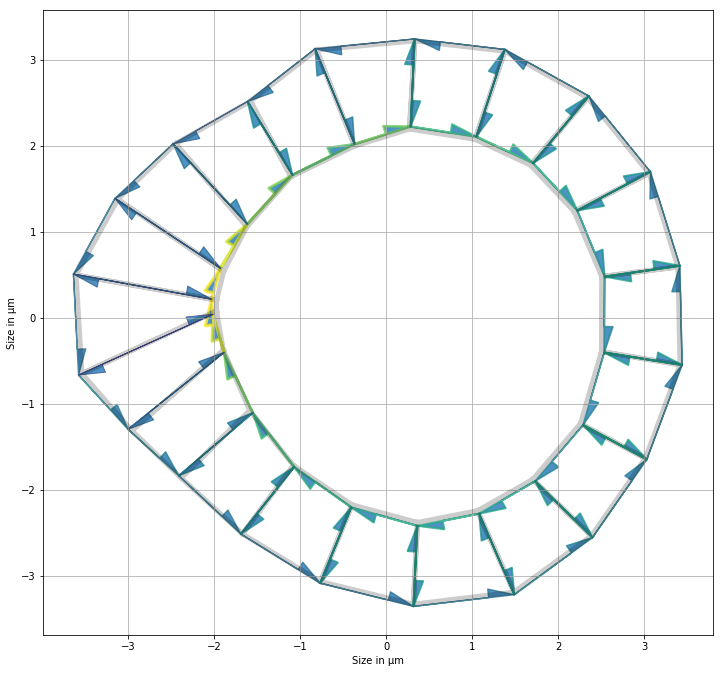

In [19]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas_copy.x[:organo.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = res_2_cst_areas_copy.x[4*organo.Nf:5*organo.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas_copy.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*organo.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo.Nf]))))

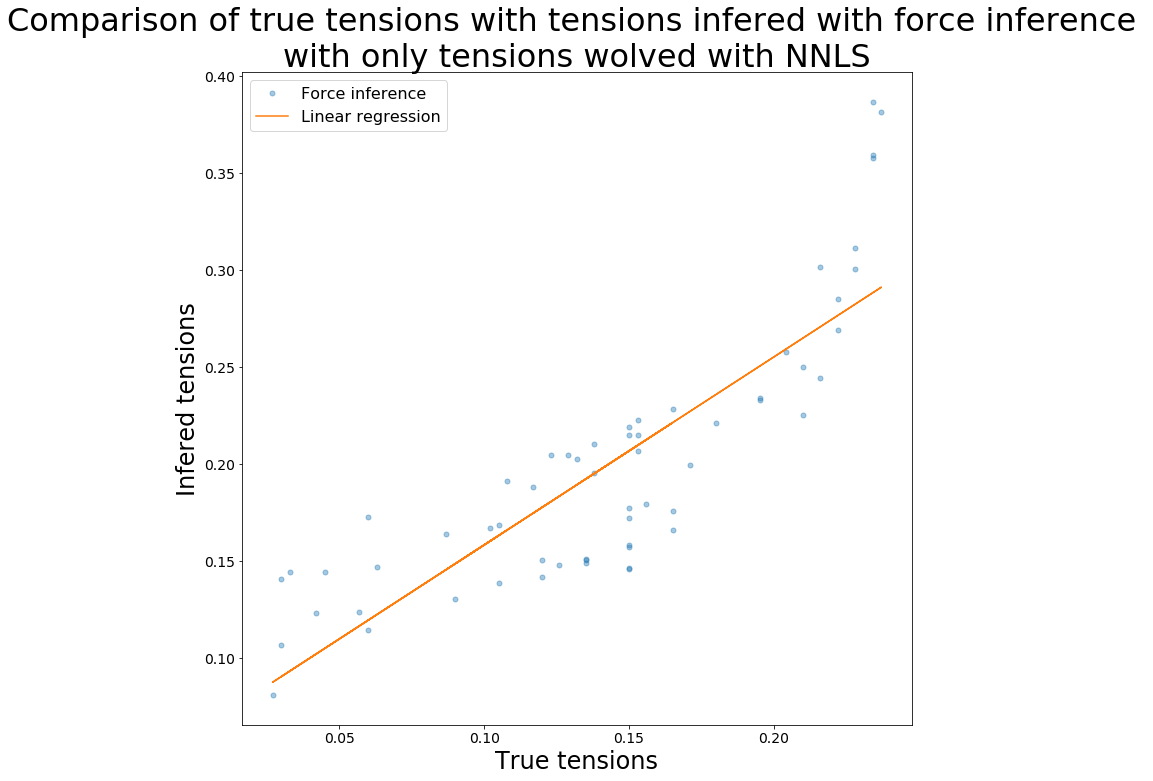

R value : 0.844982037030235 
Standard error : 0.03122434776316614


In [20]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  opt_mat_2_cst_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))